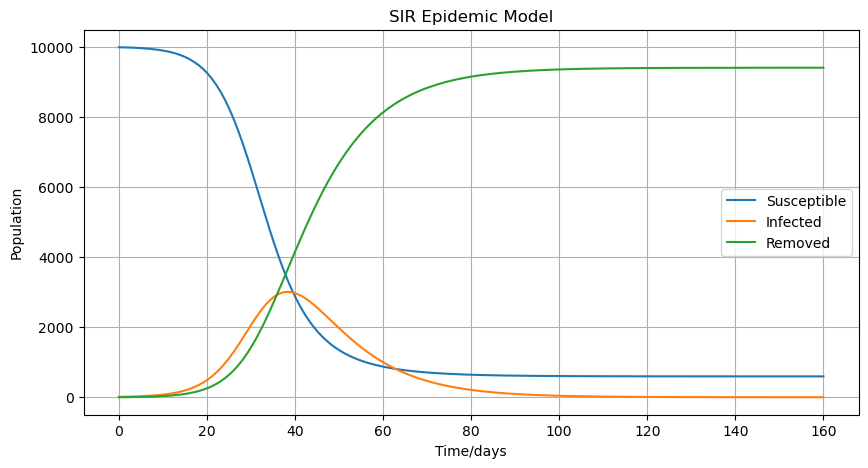

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

N = 10000
I0, R0 = 10, 0
S0 = N-I0-R0

#parameter
beta = 0.3 #infection rate
gamma = 0.1 #recover rate

#SIR ODE
def deriv(y,t,N,beta,gamma):
    S,I,R = y
    dsdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return dsdt,dIdt,dRdt

y0 = S0,I0,R0
t = np.linspace(0,160,160)

ret = odeint(deriv,y0,t,args=(N,beta,gamma))
S, I, R = ret.T

plt.figure(figsize = (10,5))
plt.plot(t,S,label='Susceptible')
plt.plot(t,I,label='Infected')
plt.plot(t,R,label='Removed')
plt.xlabel('Time/days')
plt.ylabel('Population')
plt.legend()
plt.title('SIR Epidemic Model')
plt.grid()
plt.show()